# Dev a full pymc3 model

This works but the sampling is too slow I'm too impatient.

The MAP solution is fast enough and looks good though!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy import sparse

import aesara_theano_fallback.tensor as tt
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
from aesara_theano_fallback import sparse as ttsparse
import astropy.units as un

In [3]:
fnames = np.sort(glob('/Volumes/Nibelheim/hst/data/XO-1/*.fits'))

In [4]:
self = om.Observation.from_files(fnames, planets='b', limit=1)

Backward:   0%|                                                                        | 0/1 [00:00<?, ?it/s]


In [5]:
visit = self[0]
Anames, A = om.matrix.build_noise_matrix(visit)

In [6]:
clc = lk.search_lightcurve('XO-1b', author='SPOC', exptime=120).download_all().stitch().remove_nans().flatten(501)

In [7]:
x_suppl, x_wl = clc.time.value, self.time
y_suppl, y_wl = clc.flux.value, self.average_lc / np.median(self.average_lc)
y_suppl_err, y_wl_err = clc.flux.value, self.average_lc_err / np.median(self.average_lc)

In [8]:
y = ((visit.data / visit.model) / visit.average_lc[:, None, None]).transpose([2, 0, 1]).ravel()
yerr = ((visit.error / visit.model) / visit.average_lc[:, None, None]).transpose([2, 0, 1]).ravel()

In [9]:
A_tt = ttsparse.basic.CSR(data=A.data, indices=A.indices, indptr=A.indptr, shape=A.shape)

In [10]:
with pm.Model() as model:
    y_supplmean = pm.Normal("y_supplmean", mu=1, sd=0.01, testval=1)
    u_suppl = xo.distributions.QuadLimbDark("u_suppl", testval=np.array([0.4412, 0.2312]))
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.4412, 0.2312]))
    r_star_pm = pm.Normal(
                "r_star", mu=self.st_rad, sigma=0.2 * self.st_rad, testval=self.st_rad
            )
    m_star_pm = pm.Normal(
        "m_star", mu=self.st_mass, sigma=0.2 * self.st_mass, testval=self.st_mass
            )
    r = pm.Uniform(
                "r",
                lower=self.radius * 0.1,
                upper=self.radius * 10,
                testval=self.radius,
                shape=self.nplanets,
            )
    period = pm.Normal(
                    "period",
                    mu=self.period,
                    sigma=0.05,
                    shape=self.nplanets,
                    testval=self.period,
                )
    t0 = pm.Normal(
                    "t0",
                    mu=self.t0,
                    sigma=0.01,
                    testval=self.t0,
                    shape=self.nplanets,
                )
    ror = pm.Deterministic("ror", r / r_star_pm)
    b = xo.ImpactParameter("b", ror=ror, shape=visit.nplanets)
    orbit = xo.orbits.KeplerianOrbit(
                    period=period, t0=t0, r_star=r_star_pm, m_star=m_star_pm, b=b
                )
    transit_wl = xo.LimbDarkLightCurve(u).get_light_curve(
                    orbit=orbit, r=r, t=x_wl, texp=np.median(np.diff(x_wl))
                )
    transit_suppl = xo.LimbDarkLightCurve(u_suppl).get_light_curve(
                    orbit=orbit, r=r, t=x_suppl, texp=np.median(np.diff(x_suppl))
                )
    sigma_w_inv = tt.dot(self.A.T, self.A / y_wl_err[:, None] ** 2)
    B = tt.dot(self.A.T, (y_wl / (pm.math.sum(transit_wl, axis=-1) + 1)) / y_wl_err ** 2)
    noise_model_wl = tt.dot(self.A, tt.slinalg.solve(sigma_w_inv, B))
    model_wl = (pm.math.sum(transit_wl, axis=-1) + 1) * noise_model_wl
    model_suppl = pm.math.sum(transit_suppl, axis=-1) + y_supplmean
    
    
    transit_subtime = xo.LimbDarkLightCurve([0, 0]).get_light_curve(
                    orbit=orbit, r=r, t=visit._subtime.ravel(), texp=np.median(np.diff(x_wl))
                ).reshape((visit.nplanets, visit.nt, visit.nsp))
    diag = tt.as_tensor(np.diag(np.ones(visit.nwav)))
    A_transit = ttsparse.basic.vstack([ttsparse.basic.csr_from_dense((transit_subtime[:, :, :, None] * diag[idx]).transpose([0, 3, 1, 2]).reshape((visit.nplanets, visit.nt * visit.nsp * visit.nwav))) for idx in range(visit.nwav)], format='csc').T
    #ts = pm.Normal("ts", mu=0, sigma=1000, testval=0, shape=(visit.nplanets, visit.nwav))
    
    
#     transit_subtime = xo.LimbDarkLightCurve([0, 0]).get_light_curve(
#                     orbit=orbit, r=r, t=(visit._subtime[:, :, None] * np.ones(visit.T.shape)).transpose([2, 0, 1]).ravel(), texp=np.median(np.diff(x_wl))
#                 ).reshape((visit.nwav, visit.nt, visit.nsp, visit.nplanets)).transpose([3, 1, 2, 0])
#     A_transit = ttsparse.basic.csr_from_dense((transit_subtime).reshape((visit.nplanets, visit.nt * visit.nsp * visit.nwav)).T)
    A_all = ttsparse.basic.hstack([A_tt, A_transit], format='csr')
    

    prior_sigma = ttsparse.basic.csr_from_dense(tt.as_tensor(np.diag(np.ones(A.shape[1] + (visit.nplanets * visit.nwav)) * (1/100000**2))))
    sigma_w_inv = A_all.T.dot(ttsparse.basic.row_scale(A_all, tt.as_tensor(1 / yerr ** 2))) + prior_sigma
    B = A_all.T.dot(tt.as_tensor((y / (yerr ** 2))[:, None]))[:, 0]
    pixel_model_w = tt.slinalg.solve(ttsparse.basic.dense_from_sparse(sigma_w_inv), B)
    pm.Deterministic('pixel_model_w', pixel_model_w[-visit.nplanets * visit.nwav:])
#     #pixel_model = ttsparse.basic.dense_from_sparse(A_all.dot(pixel_model_w))[:, 0]
    pm.Normal("obs_wl",
                mu=tt.concatenate([model_suppl, model_wl]),
                sigma=tt.concatenate([y_suppl_err, y_wl_err]),
                observed=(tt.concatenate([y_suppl, y_wl])),
            )
    map_soln = pmx.optimize(start=model.test_point, verbose=True)
    
# full_model = pmx.eval_in_model(A_all.dot(ttsparse.basic.csr_from_dense(pixel_model_w).T), model=model, point=map_soln).toarray()[:, 0].reshape((visit.nwav, visit.nt, visit.nsp)).transpose([1, 2, 0])

ValueError: Cannot compute test value: input 0 (SparseVariable{csr,float64}) of Op HStack(csr,float64)(SparseVariable{csr,float64}, SparseVariable{csr,float64}) missing default value.  
Backtrace when that variable is created:

  File "/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
    result = self._run_cell(
  File "/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
    return runner(coro)
  File "/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/yn/f2r51bxd7pj58243x2y_c6340000gn/T/ipykernel_88326/143443914.py", line 1, in <module>
    A_tt = ttsparse.basic.CSR(data=A.data, indices=A.indices, indptr=A.indptr, shape=A.shape)


In [ ]:
plt.scatter(x_suppl, y_suppl, c='k', s=5, label='data')
plt.scatter(x_suppl, pmx.eval_in_model(model_suppl, model=model, point=model.test_point), c='red', s=1, label='test point')
plt.scatter(x_suppl, pmx.eval_in_model(model_suppl, model=model, point=map_soln), c='green', s=1, label='MAP solution')
plt.legend()
plt.title('Supplementary Data')

In [ ]:
plt.scatter(x_wl, y_wl, c='k', s=5, label='data')
plt.scatter(x_wl, pmx.eval_in_model(model_wl, model=model, point=model.test_point), c='red', s=1, label='test point')
plt.scatter(x_wl, pmx.eval_in_model(model_wl, model=model, point=map_soln), c='green', s=1, label='MAP solution')
plt.legend()
plt.title('HST Wavelength Summed Data')

In [ ]:
plt.plot(visit.wavelength, map_soln['pixel_model_w'])

In [234]:
with model:
    trace = pmx.sample(
        tune=100,
        draws=100,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/pymc3_ext/sampling/schedule.py:33: UserWarning: there are not enough tuning steps to accomodate the tuning schedule; assigning automatically as 20%/70%/10%
  warnings.warn(
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[3], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[3], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,1,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elem

KeyboardInterrupt: 

In [207]:
import arviz as az

az.summary(trace, var_names=["r", "b", "u"])

In [ ]:
import corner
_ = corner.corner(trace, var_names=["r", "b", "u"])

In [ ]:
trace.posterior["pixel_model_w"].values.shape

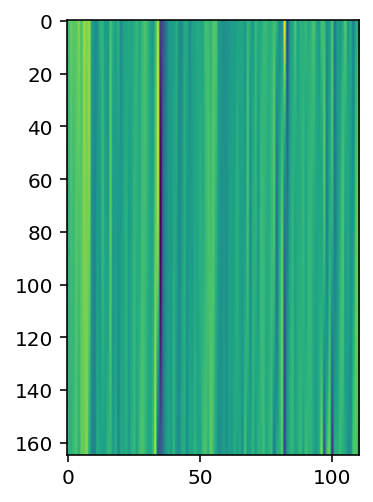

In [206]:
plt.imshow(full_model[0])

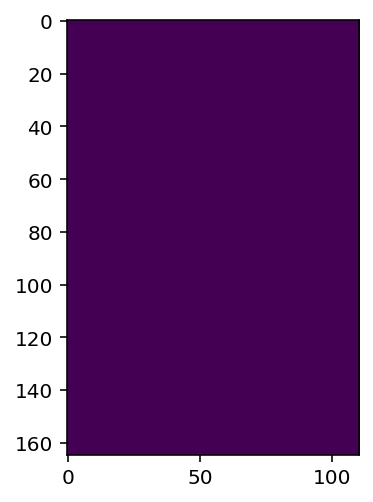

In [189]:
plt.imshow(A_transit.dot(np.random.normal(size=A_transit.shape[1])).reshape((visit.nwav, visit.nt, visit.nsp)).transpose([1, 2, 0])[0])

In [128]:
np.diag(np.ones(visit.nwav))[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [133]:
visit._subtime[:, :, None] * np.diag(np.ones(visit.nwav))[0]

array([[[2456196.07756915,       0.        ,       0.        , ...,
               0.        ,       0.        ,       0.        ],
        [2456196.07757073,       0.        ,       0.        , ...,
               0.        ,       0.        ,       0.        ],
        [2456196.0775723 ,       0.        ,       0.        , ...,
               0.        ,       0.        ,       0.        ],
        ...,
        [2456196.07782431,       0.        ,       0.        , ...,
               0.        ,       0.        ,       0.        ],
        [2456196.07782588,       0.        ,       0.        , ...,
               0.        ,       0.        ,       0.        ],
        [2456196.07782746,       0.        ,       0.        , ...,
               0.        ,       0.        ,       0.        ]],

       [[2456196.07881915,       0.        ,       0.        , ...,
               0.        ,       0.        ,       0.        ],
        [2456196.07882073,       0.        ,       0.        

(125, 165, 111)

In [109]:
map_soln

{'y_supplmean': array(1.),
 'u_suppl_quadlimbdark__': array([ 1.47384458e-06, -1.04861133e-06]),
 'u_quadlimbdark__': array([-1.29488273, -3.44423974]),
 'r_star': array(1.14116618),
 'm_star': array(1.26183952),
 'r_interval__': array([-2.34155171]),
 'b_impact__': array([0.00171981]),
 'u_suppl': array([7.07106671e-01, 3.70740227e-07]),
 'u': array([0.02869544, 0.43501514]),
 'r': array([0.13836274]),
 'ror': array([0.12124679]),
 'b': array([0.56110548]),
 'pixel_model_w': array([ 1.51847352e-03, -7.65821345e-03,  3.16756695e-03, ...,
         4.96010301e-06, -6.41841516e-05, -1.37074467e-02])}

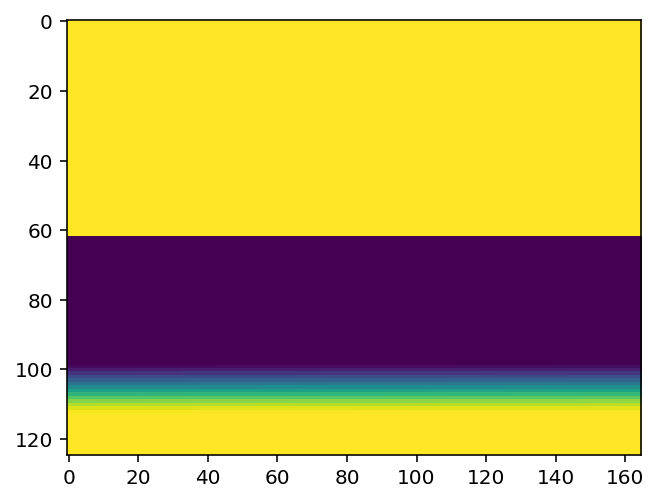

In [136]:
plt.imshow(transit_subtime)

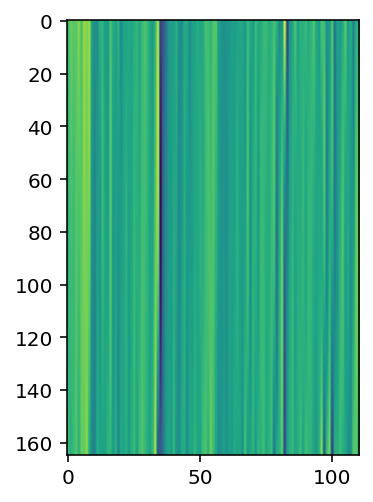

In [120]:
plt.imshow(A_all.dot(map_soln['pixel_model_w']).reshape((visit.nwav, visit.nt, visit.nsp)).transpose([1, 2, 0])[0])

In [70]:
A

<2289375x1556 sparse matrix of type '<class 'numpy.float64'>'
	with 36379770 stored elements in Compressed Sparse Row format>

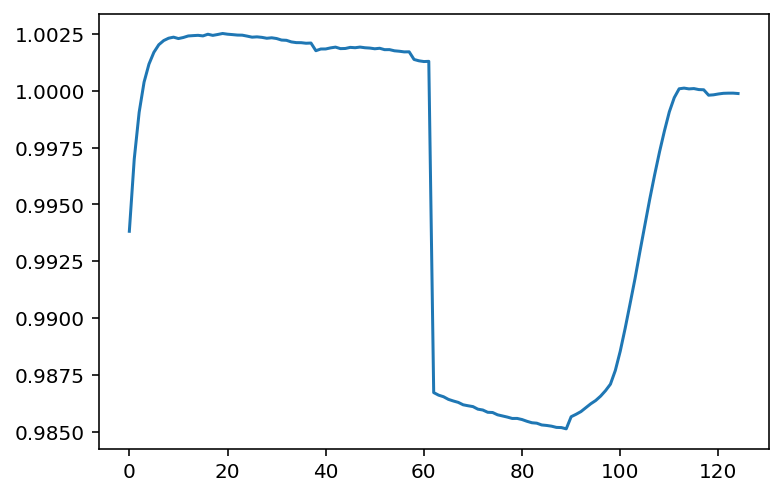

In [62]:
plt.plot(model_wl)

In [56]:
A.shape

(2289375, 1556)

In [57]:
A_transit.shape

(2289375, 1)

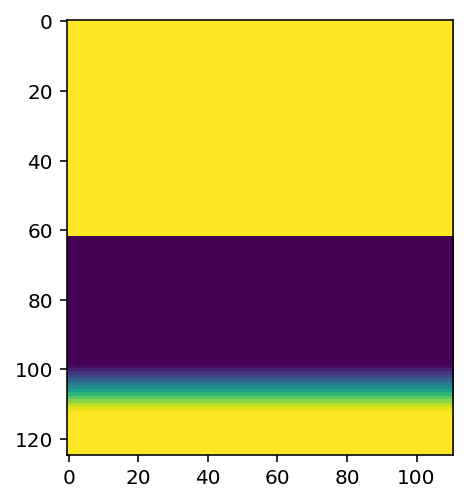

In [55]:
plt.imshow(A_transit[:, 0].reshape(visit.nt, visit.nsp, visit.nwav).sum(axis=1))

In [510]:
pmx.eval_in_model(A_all, model=model, point=map_soln)

<1680536x1587 sparse matrix of type '<class 'numpy.float64'>'
	with 26679796 stored elements in Compressed Sparse Column format>

In [507]:
pixel_model_w

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -1.96932108e-03,  1.48131017e-05, -1.54509140e-04])

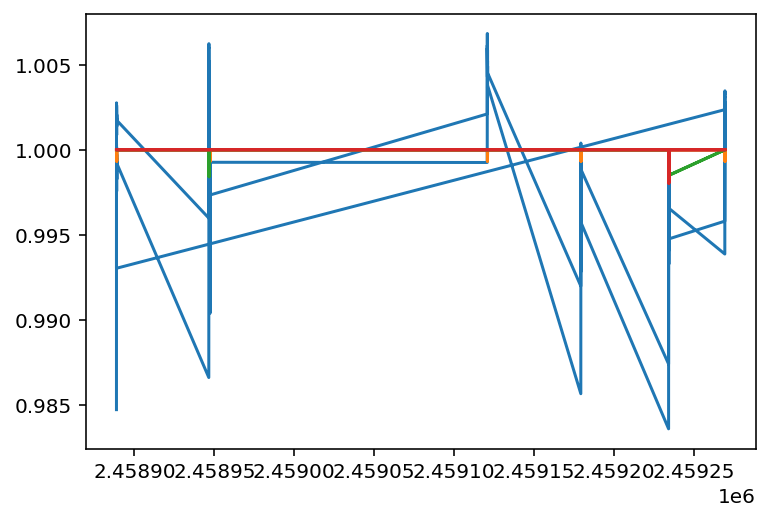

In [496]:
plt.plot(x_wl, y_wl)
plt.plot(x_wl, transit_wl + 1)

In [480]:
m = A.dot(pixel_model_w[:-3]).reshape((visit.nwav, visit.nt, visit.nsp)).transpose([1, 2, 0])

In [404]:
m = A_transit.sum(axis=-1).reshape((visit.nt, visit.nsp, visit.nwav))

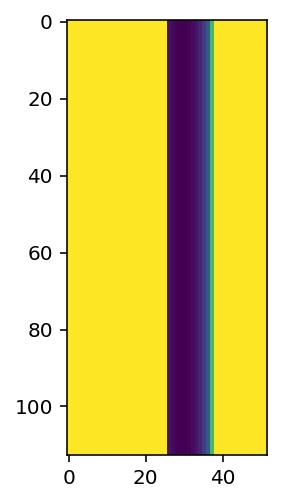

In [405]:
plt.imshow(m.sum(axis=1).T)

In [329]:
transit_subtime.shape

(3, 52, 286, 113)

In [283]:
map_soln

{'y_supplmean': array(1.),
 'u_suppl_quadlimbdark__': array([-0.19210155, -0.7168885 ]),
 'u_quadlimbdark__': array([-0.19210155, -0.7168885 ]),
 'r_star': array(0.3),
 'm_star': array(0.27),
 'r_interval__': array([-2.30258509, -2.30258509, -2.30258509]),
 'b_impact__': array([-0.05064689, -0.08125751, -0.0888918 ])}

In [280]:
y.transpose([2, 0, 1]).ravel().shape

(1680536,)

In [ ]:
map_soln

In [ ]:
plt.scatter(x_wl % self.period[0], y_wl, s=0.1)
plt.scatter(x_wl % self.period[0], pmx.eval_in_model(model_wl, model=model, point=map_soln), c='r', s=0.1)

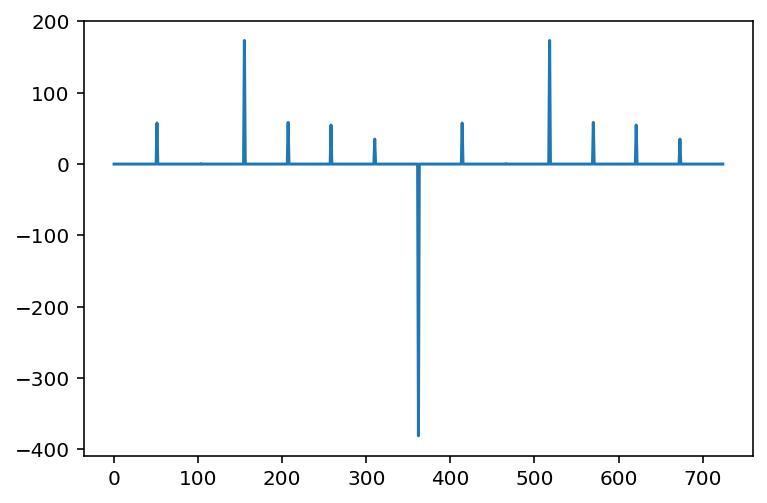

In [210]:
plt.plot(np.diff(x_wl))